# Loading Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import cv2 as cv
import os
from skimage import measure, morphology, segmentation
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import scipy.ndimage as ndimage
import pydicom
import plotly.graph_objects as go
from mpl_toolkits import mplot3d

#For further processing, intensity = -2000 is assigned for background 


# Reading the dicom image

In [2]:
dicom_file = pydicom.dcmread('/Users/rt/Desktop/College/4th year/sem 7/Project/Literature survey/Dicom/dicom/dicom_dir/ID_0000_AGE_0060_CONTRAST_1_CT.dcm')

# Displaying the dicom image before converting to hounsfield units

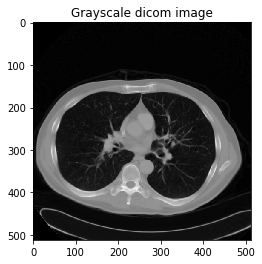

Pixel range before converting to Hounsfield unit
Max value :  1918
Min value :  0


In [3]:
#converting to pixel array
image = dicom_file.pixel_array
image = image.astype(np.uint16)

#storing the grid size for 3d plot
x, y = np.mgrid[0:image.shape[0], 0:image.shape[1]]

plt.imshow(image, cmap = 'gray')
plt.title('Grayscale dicom image')
plt.show()
print('Pixel range before converting to Hounsfield unit')
print('Max value : ',np.max(image))
print('Min value : ',np.min(image))

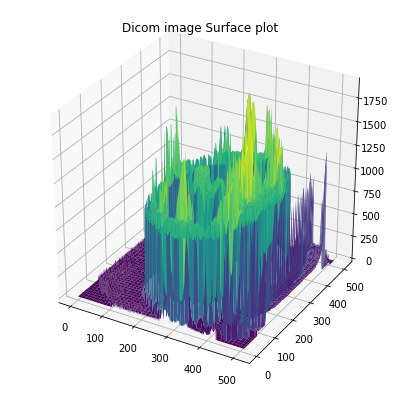

In [4]:
#Surface plot for original dicom image
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, image, cmap='viridis', edgecolor='none')
ax.set_title('Dicom image Surface plot ')
plt.show()

# Hounsfield value chart

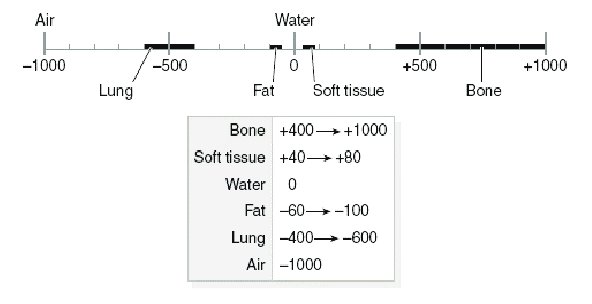

# Converting values to hounsfield units

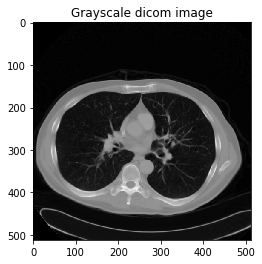

Pixel range After converting to Hounsfield unit
Max value :  1918
Min value :  0


In [5]:
image_h = image
image_h[image_h == -2000] = 0
intercept = dicom_file.RescaleIntercept
slope = dicom_file.RescaleSlope

if slope != 1:
    image_h = slope * image.astype(np.float64)
    image_h = image.astype(np.int16)

image_h = image_h + np.int16(intercept)
test_patient_images = np.array(image_h, dtype = np.int16)

plt.imshow(test_patient_images,cmap = 'gray')
plt.title('Grayscale dicom image')
plt.show()

print('Pixel range After converting to Hounsfield unit')
print('Max value : ',np.max(image))
print('Min value : ',np.min(image))

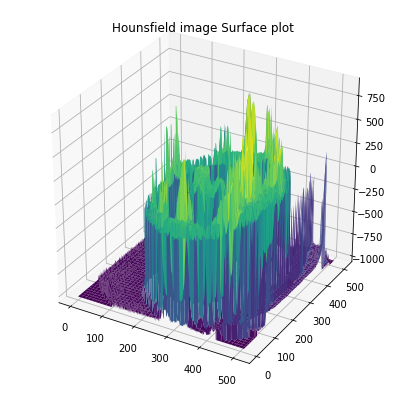

In [6]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, image_h, cmap='viridis', edgecolor='none')
ax.set_title('Hounsfield image Surface plot')
plt.show()

# Creating an internal internal marker

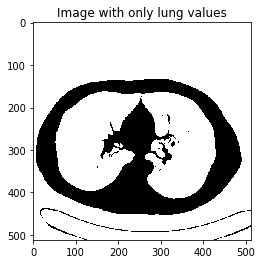

Pixel range
Max value :  True
Min value :  False


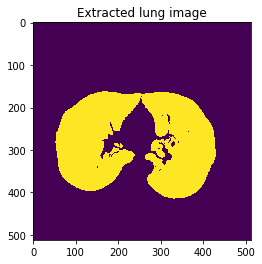

Pixel range
Max value :  True
Min value :  False


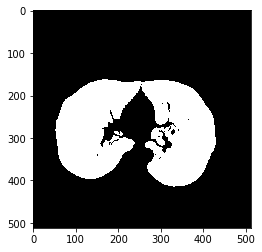

Pixel range
Max value :  True
Min value :  False


In [7]:
#for hounsfield values, lung values ranges < -400
#boolean values to be stored 

marker_internal = image_h < -400
plt.imshow(marker_internal, cmap = 'gray')
plt.title('Image with only lung values')
plt.show()
print('Pixel range')
print('Max value : ',np.max(marker_internal))
print('Min value : ',np.min(marker_internal))


#extracting only the lung region
marker_internal = segmentation.clear_border(marker_internal)
plt.imshow(marker_internal)
plt.title('Extracted lung image')
plt.show()
print('Pixel range')
print('Max value : ',np.max(marker_internal))
print('Min value : ',np.min(marker_internal))

marker_internal_labels = measure.label(marker_internal)
areas = [r.area for r in measure.regionprops(marker_internal_labels)]
areas.sort()
if len(areas) > 2:
    for region in measure.regionprops(marker_internal_labels):
        if region.area < areas[-2]:
            for coordinates in region.coords:
                marker_internal_labels[coordinates[0],coordinates[1]] = 0

marker_internal = marker_internal_labels > 0
plt.imshow(marker_internal,cmap = 'gray')
plt.show()
print('Pixel range')
print('Max value : ',np.max(marker_internal))
print('Min value : ',np.min(marker_internal))

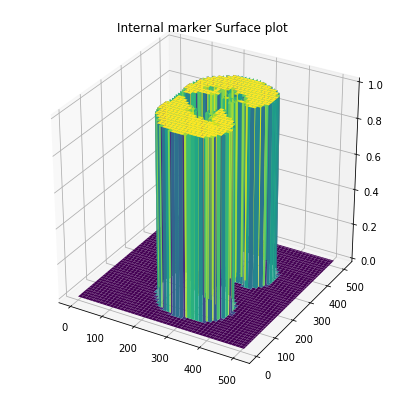

In [8]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, marker_internal, cmap='viridis', edgecolor='none')
ax.set_title('Internal marker Surface plot')
plt.show()

# Generating original image from the internal marker mask

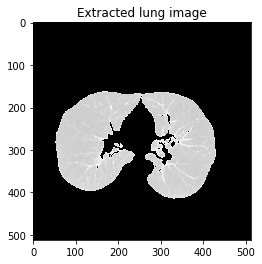

Pixel range
Max value :  623.0
Min value :  -2000.0


In [9]:
lung_image = np.where(marker_internal == 1, image, -2000*np.ones((512,512)))
plt.imshow(lung_image, cmap = 'gray')
plt.title('Extracted lung image')
plt.show()
print('Pixel range')
print('Max value : ',np.max(lung_image))
print('Min value : ',np.min(lung_image))

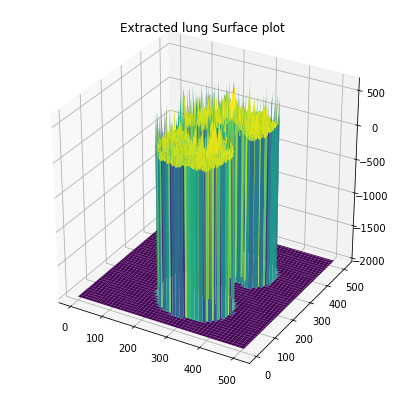

In [10]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, lung_image, cmap='viridis', edgecolor='none')
ax.set_title('Extracted lung Surface plot')
plt.show()

# Creating External marker

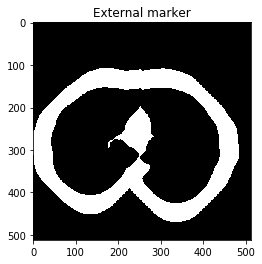

Pixel range
Max value :  True
Min value :  False


In [11]:
external_a = ndimage.binary_dilation(marker_internal, iterations = 10)
external_b = ndimage.binary_dilation(marker_internal, iterations = 55)
plt.imshow(external_a)
plt.imshow(external_b)
marker_external = external_b ^ external_a
plt.imshow(marker_external,cmap = 'gray')
plt.title('External marker')
plt.show()
print('Pixel range')
print('Max value : ',np.max(marker_external))
print('Min value : ',np.min(marker_external))

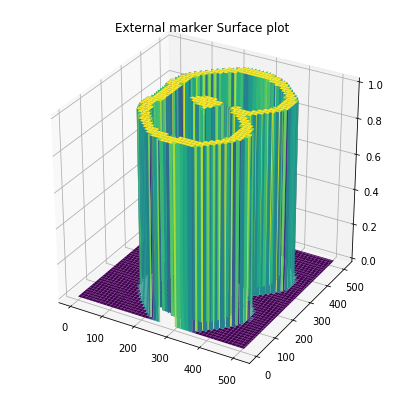

In [12]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, marker_external, cmap='viridis', edgecolor='none')
ax.set_title('External marker Surface plot')
plt.show()

# Creating a watershed marker

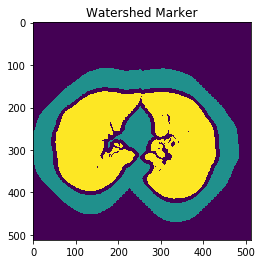

Pixel range
Max value :  255.0
Min value :  0.0


In [13]:
#creating a watershed marker from the internal & external marker
marker_watershed = np.zeros((512,512), dtype = np.uint)
marker_watershed = marker_watershed + marker_internal * 255
marker_watershed = marker_watershed + marker_external * 128
plt.imshow(marker_watershed)
plt.title('Watershed Marker')
plt.show()
print('Pixel range')
print('Max value : ',np.max(marker_watershed))
print('Min value : ',np.min(marker_watershed))

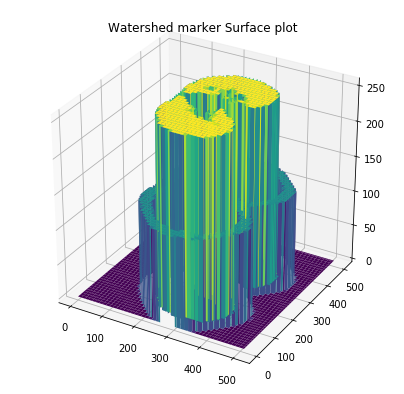

In [14]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, marker_watershed, cmap='viridis', edgecolor='none')
ax.set_title('Watershed marker Surface plot')
plt.show()

# Applying Sobel edge detector

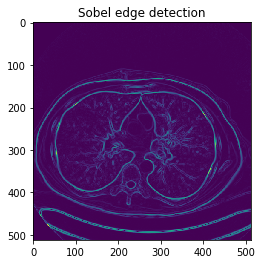

Pixel range
Max value :  255.0
Min value :  0.0


In [15]:
sobel_filtered_dx = ndimage.sobel(image_h, 1)
sobel_filtered_dy = ndimage.sobel(image_h, 0)
sobel_gradient = np.hypot(sobel_filtered_dx,sobel_filtered_dy)
sobel_gradient = sobel_gradient * 255 / np.max(sobel_gradient)
plt.imshow(sobel_gradient)
plt.title('Sobel edge detection')
plt.show()
print('Pixel range')
print('Max value : ',np.max(sobel_gradient))
print('Min value : ',np.min(sobel_gradient))

# Applying watershed segmentation for generating the lung mask

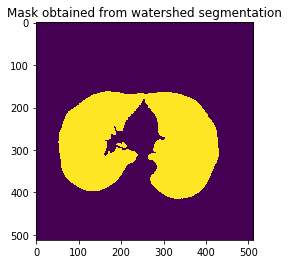

Pixel range
Max value :  255
Min value :  128


In [16]:
watershed = morphology.watershed(sobel_gradient, marker_watershed)
plt.imshow(watershed)
plt.title('Mask obtained from watershed segmentation')
plt.show()
print('Pixel range')
print('Max value : ',np.max(watershed))
print('Min value : ',np.min(watershed))

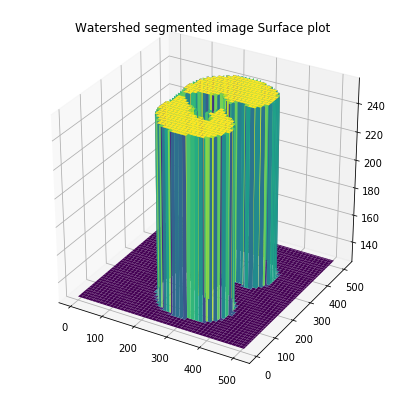

In [17]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, watershed, cmap='viridis', edgecolor='none')
ax.set_title('Watershed segmented image Surface plot')
plt.show()

# Finding outline of the lung mask

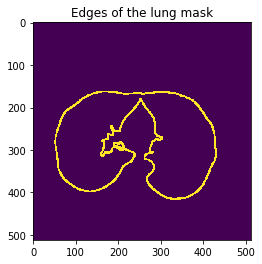

Pixel range
Max value :  True
Min value :  False


In [18]:
outline = ndimage.morphological_gradient(watershed, size = (5,5))
outline = outline.astype(bool)
plt.imshow(outline)
plt.title('Edges of the lung mask')
plt.show()
print('Pixel range')
print('Max value : ',np.max(outline))
print('Min value : ',np.min(outline))

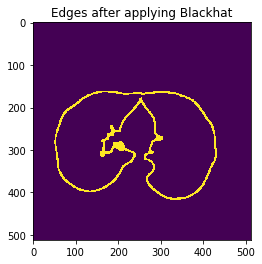

Pixel range
Max value :  True
Min value :  False


In [19]:
#applying blackhat filter for image enhancement

blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                   [0, 1, 1, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1],
                   [0, 1, 1, 1, 1, 1, 0],
                   [0, 0, 1, 1, 1, 0, 0]]

blackhat_struct = ndimage.iterate_structure(blackhat_struct, 1)
outline += ndimage.black_tophat(outline, structure=blackhat_struct)
plt.imshow(outline)
plt.title('Edges after applying Blackhat')
plt.show()
print('Pixel range')
print('Max value : ',np.max(outline))
print('Min value : ',np.min(outline))

# Re-creating mask with bitwise or

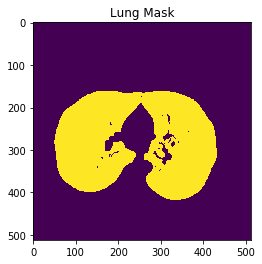

Pixel range
Max value :  True
Min value :  False


In [20]:
lungfilter = np.bitwise_or(marker_internal, outline)
plt.imshow(lungfilter)
plt.title('Lung Mask')
plt.show()

print('Pixel range')
print('Max value : ',np.max(lungfilter))
print('Min value : ',np.min(lungfilter))

# Generating image from the mask

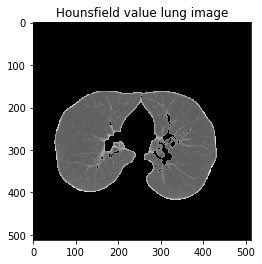

Pixel range
Max value :  894.0
Min value :  -2000.0


In [21]:
segmented = np.where(lungfilter == 1, image_h, -2000*np.ones((512,512)))
plt.imshow(segmented,cmap = 'gray')
plt.title('Hounsfield value lung image')
plt.show()

print('Pixel range')
print('Max value : ',np.max(segmented))
print('Min value : ',np.min(segmented))

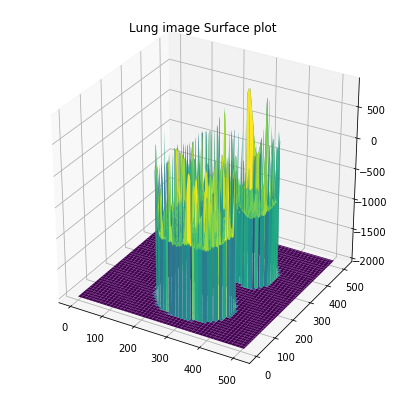

In [22]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, segmented, cmap='viridis', edgecolor='none')
ax.set_title('Lung image Surface plot')
plt.show()

# Watershed segmentation

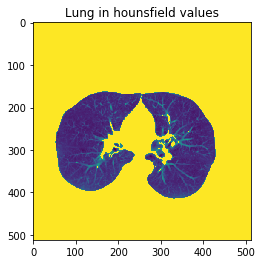

Pixel range
Max value :  0.0
Min value :  -1001.0


In [23]:
#Obtaining image from the internal marker
lung_filter = np.where(marker_internal == 1, image_h, np.zeros((512,512)))
plt.imshow(lung_filter)
plt.title('Lung in hounsfield values')
plt.show()

print('Pixel range')
print('Max value : ',np.max(lung_filter))
print('Min value : ',np.min(lung_filter))

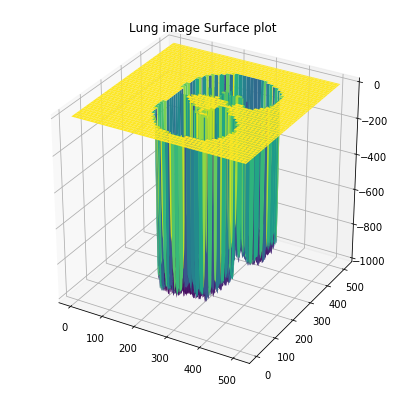

In [24]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, lung_filter, cmap='viridis', edgecolor='none')
ax.set_title('Lung image Surface plot')
plt.show()

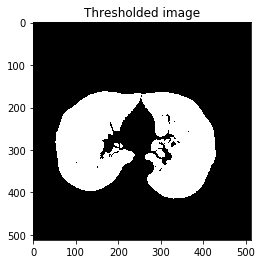

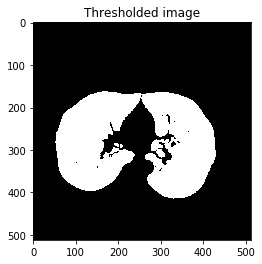

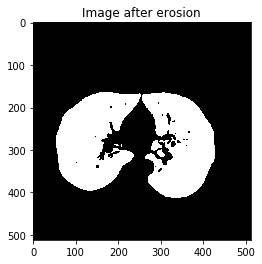

In [25]:
#Normalization
normalized = cv.normalize(lung_filter, lung_filter, 0, 255, cv.NORM_MINMAX)

#Thresholding using Otsu's method
ret, thresh = cv.threshold(np.uint8(normalized),0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.imshow(thresh, cmap = 'gray')
plt.title('Thresholded image')
plt.show()

#Using opening morphological operation
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 1)
plt.imshow(opening,cmap = 'gray')
plt.title('Thresholded image')
plt.show()

#Using Erosion morphological operation
fg = cv.erode(opening, np.ones((3,3)))
plt.imshow(fg,cmap = 'gray')
plt.title('Image after erosion')
plt.show()

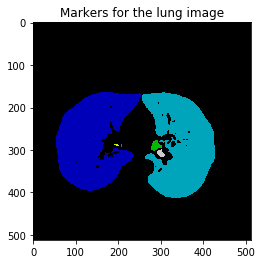

In [26]:
#Generating markers for watershed segmentation
ret, markers = cv.connectedComponents(fg)
markers = markers + 1
plt.imshow(markers, cmap = 'nipy_spectral')
plt.title('Markers for the lung image')
plt.show()

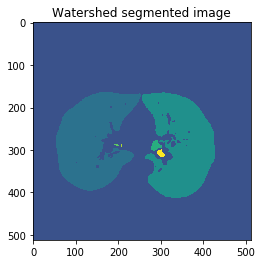

In [27]:
#Converting image to RGB (As function watershed needs a 3 channel input image)
rgb = cv.cvtColor(np.uint8(normalized), cv.COLOR_GRAY2RGB)

#watershed segmentation
watershed_seg = cv.watershed(np.uint8(rgb), markers)
plt.imshow(watershed_seg)
plt.title('Watershed segmented image')
plt.show()

# Generating houndsfield images from the watershed markers

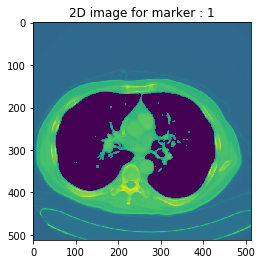

Pixel range
Max value :  894.0
Min value :  -2000.0


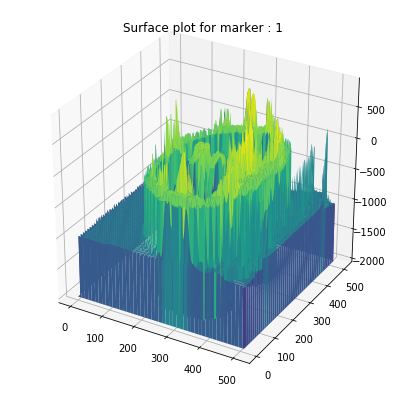

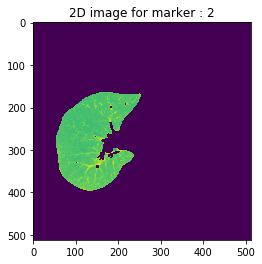

Pixel range
Max value :  -441.0
Min value :  -2000.0


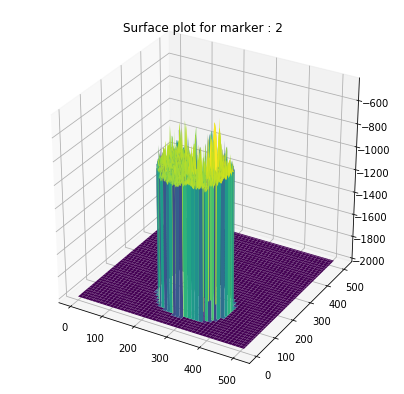

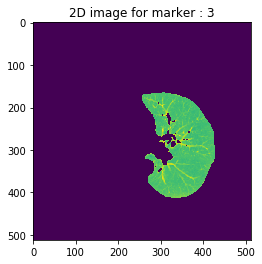

Pixel range
Max value :  -423.0
Min value :  -2000.0


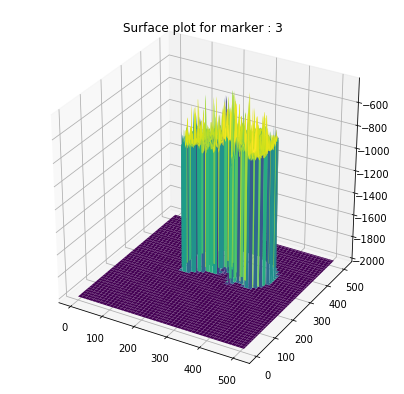

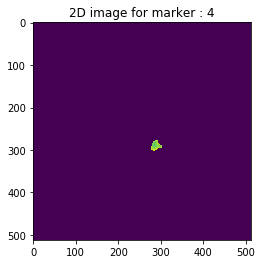

Pixel range
Max value :  -482.0
Min value :  -2000.0


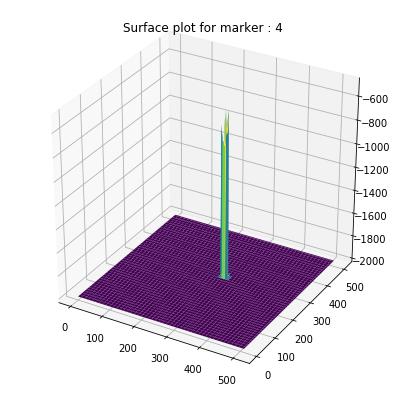

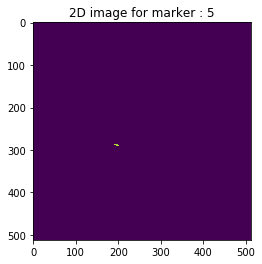

Pixel range
Max value :  -632.0
Min value :  -2000.0


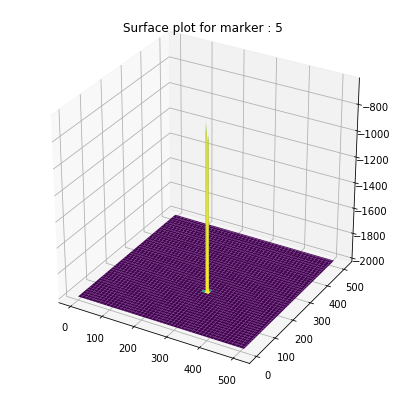

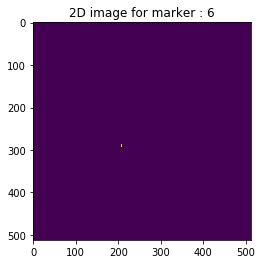

Pixel range
Max value :  -489.0
Min value :  -2000.0


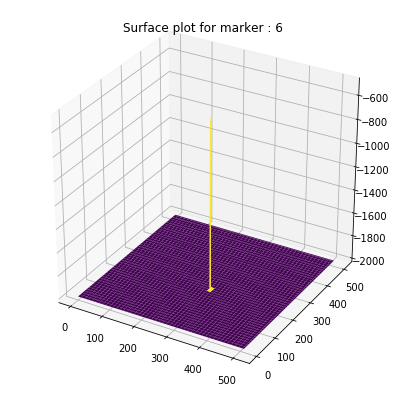

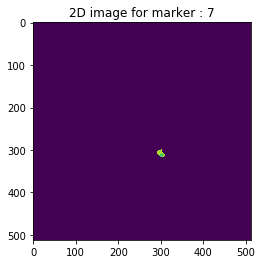

Pixel range
Max value :  -481.0
Min value :  -2000.0


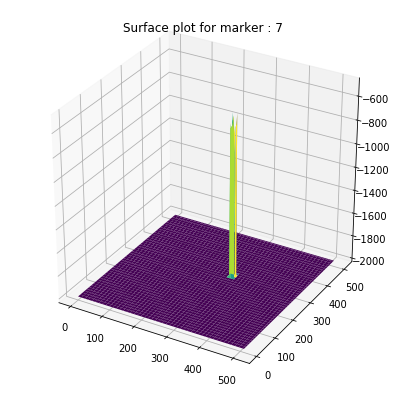

In [28]:
m = {}
for i in range(np.min(watershed_seg)+2, np.max(watershed_seg) + 1):
    #generating image wrt the marker
    temp = np.where(watershed_seg == i, image_h, -2000*np.ones((512,512)))
    m[i] = temp
    plt.imshow(temp)
    
    #2D image plot
    plt.title('2D image for marker : %i'%i)
    plt.show()
    print('Pixel range')
    print('Max value : ',np.max(temp))
    print('Min value : ',np.min(temp))
    
    #Surface plot
    fig = plt.figure(figsize = (7,7))
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, temp, cmap='viridis', edgecolor='none')
    ax.set_title('Surface plot for marker : %i'%i)
    plt.show()
    